<a href="https://colab.research.google.com/github/sharwinbobde/siamese-nn-oneshot-reproduction/blob/feature-maps/notebooks/experiments/feature_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing Omniglot experiment in the Siamese NNs for One Shot Recognition Paper

In this notebook we reproduce Table 1 in the original 
[Siamese NN Paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

[Original MSc Thesis](http://www.cs.toronto.edu/~gkoch/files/msc-thesis.pdf).

We start from this [code](https://github.com/sorenbouma/keras-oneshot) implemented in Keras and try to translate it to use the PyTorch library



--------------------------------
# How/Why Siamese Networks Work


# One-Shot Image Recognition

# Experiment Setup

# Running the experiment on Google Colab

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


## Definition of the dataset class that will hold our examples

In [0]:
class SiameseDataset(data.Dataset):
    """Dataset that reads the data from an npy file and 
    returns a pair to the loader"""
    def __init__(self, data_path=None, labels_path=None, 
                 transform=None, dataset: data.Dataset =None, 
                 data : np.ndarray = None, labels: np.ndarray = None,
                 mean : float = None, std : float = None,
                 transform_data=False):
        self.transform_data = transform_data

        # If we're given another dataset, just take that
        if dataset is not None:
            self.data = dataset.data
            self.labels = dataset.labels
            self.transforms = dataset.transforms

        # We can also pass the data and labels as an array
        elif data is not None:
            self.data = data
            self.labels = labels

            self.mean = mean
            self.std = std 

            
            self.normalize = transforms.Normalize(mean=(self.mean,),
                                                std = (self.std,))
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                self.normalize
            ])

        # If not, that means that we load it from a file
        else:
            # Load the data and labels
            self.data = np.load(data_path)
            self.labels = np.load(labels_path)

            # for training set, calculate mean and std
            # to normalize
            if mean == None and std == None:
                # stats of the dataset
                self.mean = np.mean(self.data[:,:,:])
                self.std = np.std(self.data[:,:,:])
            # for test set, use mean and std from
            # the train set to normalize
            else:
                self.mean = mean
                self.std = std
            # Normalize by default!
            self.normalize = transforms.Normalize(mean=(self.mean,),
                                                std = (self.std,))
            # We apply the transformations that are given, so we can 
            # join the datasets

            if transform is not None:
              # If we're given transforms it means
              # that we're trying to apply the affine transformations
              self.transforms = transforms.Compose([
                  transform
              ])
            else:
              # If we're not given transforms just return the
              # normalized tensor
              print("Using the default transformations")
              self.transforms = transforms.Compose([
                    transforms.ToTensor(),
                    self.normalize                                
              ])
              
    def __len__(self):
        return len(self.data)
    
    def get_images(self, index):
        _x1 = self.data[index,0,:,:]
        _x2 = self.data[index,1,:,:]
        label = self.labels[index]
        return Image.fromarray(_x1), Image.fromarray(_x2), label
        
    
    def __getitem__(self, index):
        """ Gets the next pair from 
        the dataset and its corresponding label
        (0 or 1 depending on if they're the same
        or a different letter)"""
        _x1 = self.data[index,0,:,:]
        _x2 = self.data[index,1,:,:]
        label = self.labels[index]
        
        # Convert to PIL Images so 
        # we can transform them with affine transforms
        # Just needed to generate the dataset
        if self.transform_data:
            _x1 = Image.fromarray(_x1)
            _x2 = Image.fromarray(_x2)
            
            # we need to convert the x's to images to apply the transforms
            return np.array(self.transforms(_x1)), np.array(self.transforms(_x2)), label
        else:
          # We're trying to train the dataset, so give
          # the data in float32 version that's better for training
          # and apply the ToTensor and normalization transformations
            _x1 = _x1.astype(np.float32)
            _x2 = _x2.astype(np.float32)
            label = label.astype(np.float32)
            return self.transforms(_x1), self.transforms(_x2), label
    
# Some easy functions to visualize the data 
def show_pair(x1, x2, lab):
    """Function to show two images of the dataset side by side"""
    # x1 = x1.numpy()
    # x2 = x2.numpy()
    f ,(ax1, ax2) = plt.subplots(1, 2, sharey= True)
    ax1.imshow(x1.squeeze())
    ax2.imshow(x2.squeeze())
    plt.show()
    print('same' if lab == 1 else 'different')
    
def show_image_pair(i1, i2, lab):
    f ,(ax1, ax2) = plt.subplots(1, 2, sharey= True)
    ax1.imshow(i1)
    ax2.imshow(i2)
    plt.show()
    print('same' if lab == 1 else 'different')
    

### Set up the folder in Google Drive and define the data path

In [4]:
import os
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Deep Learning Q3"

# Change the current directory to the path so it's more comfortable to work
path = "/content/drive/My Drive/Deep Learning Q3"
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
'Choose a Paper.gdoc'   datasets   generated   saved_models   Seminar


## In case we want to augment the dataset we can run the function defined below

For each sample the fucntion generates 8x affine transformed samples of that pair and returns a new dataset with the original images and the augmented samples

In [0]:
# In case we want to create affine transformations...
import gc


def augment_dataset(d: SiameseDataset) -> SiameseDataset:
  """ Augments the dataset and returns a siamese dataset
  with 9x as much data, the original data in the argument dataset
  plus 8 affine transformations of that input data"""
  # Create a data loader of the dataset
  loader = data.DataLoader(d, batch_size=15000)

  # Altered samples of the input data
  _altered = None
  mean = None
  std = None

  # Check the size of the batches and so on
  # Read in batches of 15000, and do it 
  for j in range(8):
      gc.collect()
      print("starting with round ",j)
      for i, (x1, x2, _) in enumerate(loader):
          if i % 1 == 0:
              print(i)
          x1 = np.expand_dims(x1, 1)
          x2 = np.expand_dims(x2, 1)
          # concatenate the arrays by their second axis
          _data = np.concatenate((x1,x2), axis = 1)
          _mean = np.mean(_data)
          _std = np.std(_data)
          if mean is None:
            mean = _mean
            std = _std
          else:
            mean = (mean*len(_altered) +  _mean*len(_data))/(len(_altered)+len(_data))
            std = (std*len(_altered) +  _std*len(_data))/(len(_altered)+len(_data))
          # add them to the dataset
          if _altered is None:
              _altered = _data
          else:
              # Concatenate the existing data and the new batch
              _altered = np.concatenate((_altered, _data), axis = 0)
      
      print(f'Size of the datasets -> {_altered.shape}')

  # Now create a new dataset with the newly defined data
  # Concatenate the original dataset with the new one
  all_data = np.concatenate((d.data, _altered), axis = 0)
  labels = np.tile(d.labels, 9)
  # Add mean of the original datset
  mean = (mean*len(_altered) +  d.mean*len(d))/(len(_altered)+len(d))
  std = (std*len(_altered) +  d.std*len(d))/(len(_altered)+len(d))
  d = SiameseDataset(data = all_data, labels = labels, mean = mean, std = std)
  return d

## Load the training and validation data

In case we want to work with the affine transformations we use the part of the code that calls transform dataset



In [0]:
# define the paths of the training data
train_data_path = "datasets/trainX_30k.npy"
train_labels_path = "datasets/trainY_30k.npy"

# Affine transformations to be done on the train data
affine = transforms.RandomAffine(degrees = (-10,10), 
                                 translate=(0.1,0.1),
                                 scale = (0.8, 1.2),
                                 shear = (-0.3, 0.3), 
                                 fillcolor=255)

# In order to augment the dataset the dataset has to be created with
# some extra parameters and call the function defined below
train_d = SiameseDataset(train_data_path, train_labels_path, transform_data=True, transform=affine)
print(f"Mean of {train_d.mean} and {train_d.std}")
print("Loaded data")
train_d = augment_dataset(train_d)

Mean of 236.38998936507937 and 66.32661770415308
Loaded data
starting with round  0
0
1
Size of the datasets -> (30000, 2, 105, 105)
starting with round  1
0
1
Size of the datasets -> (60000, 2, 105, 105)
starting with round  2
0
1
Size of the datasets -> (90000, 2, 105, 105)
starting with round  3
0
1
Size of the datasets -> (120000, 2, 105, 105)
starting with round  4
0
1
Size of the datasets -> (150000, 2, 105, 105)
starting with round  5
0
1
Size of the datasets -> (180000, 2, 105, 105)
starting with round  6
0
1
Size of the datasets -> (210000, 2, 105, 105)
starting with round  7
0
1
Size of the datasets -> (240000, 2, 105, 105)


In [14]:
# validation data
valid_data_path = "datasets/validationX.npy"
valid_labels_path = "datasets/validationY.npy"
valid_d = SiameseDataset(valid_data_path, valid_labels_path)
print("Loaded validation set with shape ",valid_d.data.shape)
print(f"Mean of {valid_d.mean} and {valid_d.std}")

Using the default transformations
Loaded validation set with shape  (10000, 2, 105, 105)
Mean of 234.00379959183672 and 70.09415576566917


In [0]:
# test data
test_data_path = "datasets/testX.npy"
test_labels_path = "datasets/testY.npy"
# test_d = SiameseDataset(test_data_path, test_labels_path)
# print("Loaded test set with shape ",test_d.data.shape)
# print(f"Mean of {test_d.mean} and {test_d.std}")

-------------------------------------
## Definition of the network architecture

In [0]:
class ConvNet(nn.Module):
  """ Convolutional NN used in pair inside the siamese Network """
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, 10)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64, 128, 7)
    self.conv3 = nn.Conv2d(128,128,4)
    self.conv4 = nn.Conv2d(128,256, 4)
    self.fc1 = nn.Linear(256*6*6, 4096)
  
  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.pool(F.relu(self.conv3(out)))
    out = F.relu(self.conv4(out))
    out = out.view(-1, 256*6*6)
    # We get the h feature vectors
    out = torch.sigmoid(self.fc1(out))
    return out

class SiameseNet(nn.Module):
  """Siamese Net combining two ConvNets"""
  def __init__(self, net):
    # Receives a net as a parameter, we can just have 1 net 
    # but do the forward pass twice! and then just update once, much more 
    # elegant
    super(SiameseNet, self).__init__()
    # Instantiate two of the same class
    self.convnet = net
    # Final layer and output
    self.prediction_layer = nn.Linear(4096,1)

  def forward(self,x1, x2):
    """Computes the forward given two images"""
    h1 = self.convnet(x1)
    h2 = self.convnet(x2)
    h = self.calculate_l1_distance(h1, h2)
    out = self.prediction_layer(h)
    return out
  
  def calculate_l1_distance(self, h1, h2):
    """Calculates l1 distance between the two given vectors"""
    return torch.abs(h1-h2)

torch.manual_seed(12)

# How to initialize the weights according to the paper
def weights_init(model):
  np.random.seed(12)
  if isinstance(model, nn.Conv2d):
    nn.init.normal_(model.weight, mean = 0.0, std = 1e-2)
    nn.init.normal_(model.bias, mean=0.5, std = 1e-2)
  elif isinstance(model, nn.Linear):
    nn.init.normal_(model.weight, mean= 0.0, std = 0.2)
    nn.init.normal_(model.bias, mean=0.5, std = 1e-2)



### Create the Siamese Network and Initialize weights according to specifications
- Conv layers: 
  - Weights: Normal(0, 1e-2)
  - Bias: Normal(0.5, 1e-2)
- Linear layers: 
  - Weights: Normal(0, 0.2)
  - Bias: Normal(0.5, 1e-2)

In [7]:
conv = ConvNet()
siamese = SiameseNet(conv)
siamese.apply(weights_init)

# Send the network to the GPU if available
#device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
siamese.to(device)

SiameseNet(
  (convnet): ConvNet(
    (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  )
  (prediction_layer): Linear(in_features=4096, out_features=1, bias=True)
)

---
## Hyperparameter Setting 

In [0]:
import torch.optim as optim

learning_rate = 3e-4
regularization = 2e-4
# Learning rate decay per epoch
# lr_decay_rate = 0.9

optimizer = optim.Adam(
    [
     {"params": siamese.convnet.parameters()},
     {"params": siamese.prediction_layer.parameters(), "weight_decay": 1e-3}
    ],
    lr = learning_rate,
    weight_decay = regularization
)

n_epochs = 200
# momentum = 0.7

### Define the Loss (CrossEntropy) and the Adam optimizer

We set two different weight decay rates as done in the keras code, as it certainly shows really good results this way, as well as a fixed (could be reduced in the future) learning rate of 3e-4 using the Adam Optimizer

We choose BCEWithLogits in order to improve the stability of teh network compared to when we use just BCE, since it makes use of the log sum exp trick thus avoiding underflow.

In [0]:
criterion = nn.BCEWithLogitsLoss()

# We shouls change the momentum as the network trains, right now it's to low
#optimizer = optim.SGD(siamese.parameters(), lr = 0.1, momentum=momentum, weight_decay=weight_decay)

# optim_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_decay_rate)

---------------------------------
## Training and Validation

In [0]:
def train(model, train_data_loader, validate_data_loader,
          model_save_path, checkpoint_path,
          validate_every = 10 , save_every = 50):
  """ Train the network with two parameters, one is how often should we validate
  and the other is how often should we save a checkpoint"""

  best_accuracy = 0

  # define the loader of the dataset


  for epoch in range(n_epochs):
    running_loss = 0.0
    i = 0
    
    for X1, X2, y in train_data_loader:
      # set network to learning mode
      model.train()

      # send to gpu
      X1 = X1.to(device)
      X2 = X2.to(device)
      y = y.to(device)
      
      # make gradients zero before forward prop
      optimizer.zero_grad()

      # reshape inputs
      X1 = X1.view(-1, 1, 105, 105)
      X2 = X2.view(-1, 1, 105, 105)
      y = y.view(-1, 1)

      # forward prop
      outputs = model(X1, X2)

      # compute loss
      loss = criterion(outputs, y)

      # backprop and gradient descent step
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 50 == 0:
        print('[%d, %5d] loss: %.3f lr: %.5f' %
                  (epoch + 1, i + 1, running_loss / (i+1), optimizer.param_groups[0]['lr']))
      i+=1

    # Update the learning rate
    # optim_scheduler.step()

    # every `validate_every` epochs,
    # get metrics from validation set
    if epoch % validate_every == 0:
      accuracy = validate(model, validate_data_loader)

      # if accuracy is higest till now,
      # save model
      if accuracy > best_accuracy:
        print("Saving best model")
        best_accuracy = accuracy
        torch.save(model.state_dict(), model_save_path)

    # save model every `save_every` epochs
    if epoch > 0 and epoch % save_every == 0:
      torch.save(model.state_dict(), checkpoint_path)


## Validation Loop

In this validation loop we loop through the validation set and calculate the accuracy of the model.

We can do this as often as it is said in the training loop. For a thorough evaluation we can use validate_every= 1

In [0]:
def validate(model, data_loader):
  """ Validates the model and computes the accuracy"""
  
  # set network to validation mode
  model.eval()
  print("Validating model!")

  correct = 0
  total = 0
  with torch.no_grad():
    for x1, x2, y in data_loader:

      # Send data to device
      x1 = x1.to(device)
      x2= x2.to(device)
      y = y.to(device)

      # Appropriate view
      x1 = x1.view(-1, 1, 105, 105)
      x2 = x2.view(-1, 1, 105, 105)
      y = y.view(-1,1)

      # forward prop
      outputs = model(x1, x2)
      # Translate the outputs to 0 or 1
      predicted = torch.round(torch.sigmoid(outputs))

      total += y.size(0)
      correct += (predicted == y).sum().item()
    
    # return the accuracy
    print("Accuracy of the network on the val set %.3f %%" % (100*correct /total))
    return 100*correct/total

---
## Running the Experiment

In [0]:
model_save_path = os.path.join("saved_models", "best240k.th")
checkpoint_path = os.path.join("saved_models", "checkpoint.th")

In [0]:
train_loader = data.DataLoader(train_d, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(valid_d, shuffle=True, batch_size=128, pin_memory=True, num_workers=4)

train(siamese, train_loader, val_loader, model_save_path, checkpoint_path, validate_every=1) 

# Validating on the Test Set

In [15]:
# load best model for testing
siamese.load_state_dict(torch.load(model_save_path, map_location=device))
# create data loader for test set
test_loader = data.DataLoader(test_d, shuffle=True, batch_size=128, pin_memory=True, num_workers=4)
validate(siamese, test_loader)

Validating model!
Accuracy of the network on the val set 93.240 %


93.24

# Feature Maps

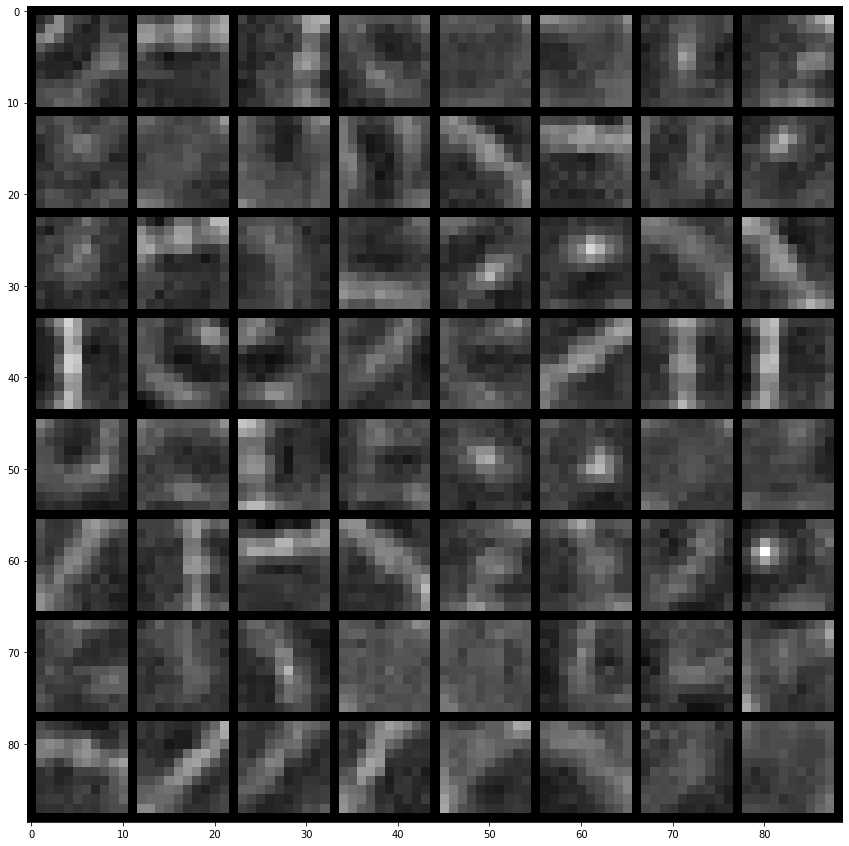

In [85]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# load model from save path
siamese.load_state_dict(torch.load(model_save_path, map_location=device))

# get filter from 1st conv layer
kernels = siamese.convnet.conv1.weight.detach().cpu().clone()

# plot the image in a grid
fig, ax = plt.subplots(figsize=(15, 15))
img = make_grid(kernels, normalize=True, padding=1)

# depth dimension should be the last one while plotting using imshow
ax.imshow(img.permute(1, 2, 0))